In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
import numpy as np
%matplotlib inline

In [29]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [30]:
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [31]:
beach_image_path = "C:/Users/allan/OneDrive/Desktop/Beach_test_image.jpg"

In [32]:
img = tf.io.read_file(beach_image_path)

In [33]:
img = tf.image.decode_jpeg(img, channels = 3)

In [34]:
converted_img = tf.image.convert_image_dtype(img, tf.float32)
converted_img = tf.expand_dims(converted_img, axis = 0)

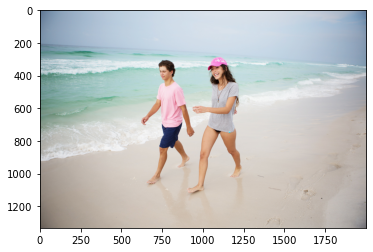

In [35]:
plt.imshow(converted_img[0])

In [36]:
print(converted_img.shape)

(1, 1333, 2000, 3)


In [37]:
predictions = detector(converted_img)

In [340]:
def get_intersection_over_union(rect1, rect2):
    rect1_top_left = rect1.get_xy()
    rect1_width = rect1.get_width()
    rect1_height = rect1.get_height()
    
    rect2_top_left = rect2.get_xy()
    rect2_width = rect2.get_width()
    rect2_height = rect2.get_height()
    
    #Calculate points that's needed for the formula
    rect1_left = rect1_top_left[0]
    rect1_top = rect1_top_left[1]
    rect1_right = rect1_left + rect1_width
    rect1_bottom = rect1_top + rect1_height
    
    rect2_left = rect2_top_left[0]
    rect2_top = rect2_top_left[1]
    rect2_right = rect2_left + rect2_width
    rect2_bottom = rect2_top + rect2_height
    
    x_overlap = max(0, min(rect1_right, rect2_right) - max(rect1_left, rect2_left))
    y_overlap = max(0, min(rect1_bottom, rect2_bottom) - max(rect1_top, rect2_top))


    intersection_area = x_overlap * y_overlap
    rect1_area = rect1_width * rect1_height
    rect2_area = rect2_width * rect2_height
    combined_area = rect1_area + rect2_area
    
    union_area = combined_area - intersection_area
    intersection_over_union = intersection_area/union_area
    #print("Intersection area is {0} and ratio is {1}".format(intersection_area, intersection_over_union))
   
    return rect1_area, rect2_area, intersection_over_union, intersection_area

In [370]:
def is_IoU_too_high(new_patch, list_of_patches):
    for single_patch in list_of_patches:
        area1, area2, intersection_over_union, intersection = get_intersection_over_union(new_patch, single_patch)
#         if intersection > 0.95:
#             return True
        if intersection_over_union > 0.85:
            return True

def filter_list_of_patches(new_patch, list_of_patches):
    if len(list_of_patches) == 0: #If the list is empty, just append the new patch to the list
        list_of_patches.append(new_patch)
        #print("first patch added")
        return list_of_patches
    else:
        #You have to check if any of the patches in the list have IoU over 0.85
        if not is_IoU_too_high(new_patch, list_of_patches):
            list_of_patches.append(new_patch)            
    return list_of_patches
                
                    
                

In [371]:
def draw_all_bounding_boxes(image_path, list_of_patches): #Once I get the list of patches here, I should filter them down
    im = PIL.Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(im)
    
    for patch in list_of_patches:
        ax.add_patch(patch)
    plt.show()
    pass

In [372]:
def define_rectangles(indices_list, image_path, image, predictions_tensor):
    #Get the image dimensions
    height = image.shape[1]
    width = image.shape[2]
    
    #Create an empty list of patches
    list_of_patches = []
    #Loop through the indices list to draw all bounding boxes
    for index in indices_list:
        #print("Adding index {0}".format(index))
        #Get the bounding box dimensions for 1 object
        bounding_box_scaled_dimensions = predictions_tensor['detection_boxes'][index].numpy()
        #Calculate all the coordinates needed for 1 object's bounding box
        xCoord0 = bounding_box_scaled_dimensions[1]*width
        yCoord0 = bounding_box_scaled_dimensions[0]*height
        bounding_box_width = (bounding_box_scaled_dimensions[3]- bounding_box_scaled_dimensions[1])*width
        bounding_box_height = (bounding_box_scaled_dimensions[2]- bounding_box_scaled_dimensions[0])*height
        #Create a patch
        rect = patches.Rectangle((xCoord0, yCoord0), bounding_box_width, bounding_box_height, linewidth = 2, edgecolor = 'r', facecolor = 'none')

        #Filter the list of patches here. Instead of adding it directly, we use the filter function
        list_of_patches = filter_list_of_patches(rect, list_of_patches)
        pass
    #Draw all patches
    draw_all_bounding_boxes(image_path, list_of_patches)
    pass

In [373]:
def get_valid_bounding_boxes(predictions_tensor):
    #predictions['detection_scores']
    counter = 0
    index_list = []
    prediction_scores_array = np.array(predictions_tensor['detection_scores'], dtype = 'float32')
    for index, confidence in enumerate(prediction_scores_array):
        if confidence >= 0.3:
            counter +=1
            #print(index)
            index_list.append(index)
        else:
            break
        pass
    return index_list


In [374]:
def get_valid_indices(predictions_tensor):
    list_of_indices = []
    array = np.array(predictions_tensor['detection_class_entities'], dtype = 'str')
    index_list = get_valid_bounding_boxes(predictions_tensor)
    for index in index_list:
        if array[index] == 'Woman' or array[index] == "Man" or array[index] == "Person":
            list_of_indices.append(index)
    return list_of_indices


#define_rectangles(get_valid_indices(predictions), beach_image_path, converted_image, predictions)

#draw_bounding_boxes > get_valid_indices > get_valid_bounding_boxes > draw_all_bounding_boxes

In [375]:
def locate_objects_for_image(image_path):
    #Prepare the image
    
    #Read the image
    img = tf.io.read_file(image_path)
    #Decode the image
    img = tf.image.decode_jpeg(img, channels = 3)
    #Convert to float32
    converted_img = tf.image.convert_image_dtype(img, tf.float32)
    #Expand dims so it is compatible with the model
    converted_img = tf.expand_dims(converted_img, axis = 0)
    #Draw the initial image
    #plt.imshow(converted_img[0])
    
    #Object detection part starts here
    predictions_tensor = detector(converted_img)

    #Temporarily freezing it
    #indices_list = get_valid_indices(predictions_tensor)
    
    indices_list = []
    for index, score in enumerate(predictions['detection_scores']):
        if score > 0.4:
            indices_list.append(index)
        else:
            break
    
    #indices_list = [x for x in range(5)]
    define_rectangles(indices_list, image_path, converted_img, predictions_tensor)
    pass


In [376]:
football_image_path = "C:/Users/allan/OneDrive/Desktop/PES_Image.jpg"

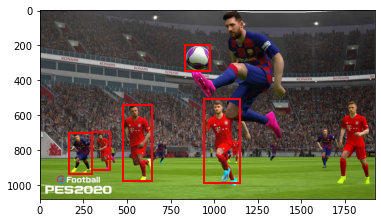

In [377]:
locate_objects_for_image(football_image_path)

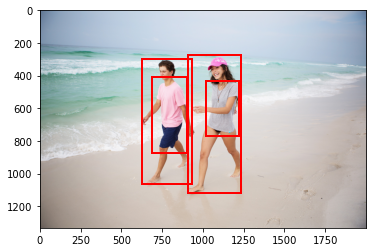

In [378]:
locate_objects_for_image(beach_image_path)